In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

from prophet import Prophet

import folium
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim

home_rate = .14
public_rate = 0.30
public_activation_fee = 1.50

gas = 3.40
mpg = 24.4

In [2]:
charging_path = "charging.csv"
driving_path = "driving.csv"

charging_data = pd.read_csv(charging_path)
driving_data = pd.read_csv(driving_path)



driving_data.head()


,date,start_time,start_bat,end_time,end_bat,miles,average_m/kwh
0,3/31/2025,8:34,95,9:26,82,21.4,5.5
1,3/31/2025,16:46,82,17:23,70,14.2,4.7
2,3/31/2025,20:16,70,20:53,46,30.3,4.5
3,4/1/2025,8:25,95,9:24,81,23.5,5.3
4,4/1/2025,16:42,81,16:03,60,30.0,5.0


In [3]:
charging_data.head()

,date,charge_place,charge_time,charge_amount
0,3/31/2025,Home,1:58:35,13.4
1,4/1/2025,Home,2:28:12,16.8
2,4/2/2025,Home,1:28:56,10.0
3,4/3/2025,Home,1:58:33,13.4
4,4/4/2025,Home,1:58:31,13.4


In [4]:
def calculate_session_cost(row):
    if row["charge_place"].lower() == "home":
        return row["charge_amount"] * home_rate
    elif row["charge_place"].lower() == "public":
        return (row["charge_amount"] * public_rate) + public_activation_fee
    else:
        return 0

In [5]:
charging_data["cost"] = charging_data.apply(calculate_session_cost, axis=1)

In [6]:
charging_data["cost"] = charging_data["cost"].round(2)

In [7]:
print(charging_data)

         date charge_place charge_time  charge_amount  cost
0   3/31/2025         Home     1:58:35           13.4  1.88
1    4/1/2025         Home     2:28:12           16.8  2.35
2    4/2/2025         Home     1:28:56           10.0  1.40
3    4/3/2025         Home     1:58:33           13.4  1.88
4    4/4/2025         Home     1:58:31           13.4  1.88
5    4/7/2025         Home     1:58:33           13.4  1.88
6    4/9/2025         Home     1:58:33           13.4  1.88
7   4/10/2025         Home     1:58:33           13.4  1.88
8   4/11/2025         Home     1:58:33           13.4  1.88
9   4/13/2025         Home     3:57:06           21.7  3.04
10  4/15/2025         Home     2:57:43           20.1  2.81
11  4/16/2025         Home     1:58:33           13.4  1.88
12  4/17/2025         Home     1:28:57           10.0  1.40
13  4/18/2025         Home     1:28:58           10.0  1.40
14  4/19/2025         Home     2:05:48           14.2  1.99
15  4/20/2025         Home     0:33:38  

In [8]:
driving_data["trip_cost"] = (driving_data["miles"] / mpg) * gas
driving_data["trip_cost"] = driving_data["trip_cost"].round(2)

In [9]:
driving_data["date"] = pd.to_datetime(driving_data["date"])

daily_summary = driving_data.groupby("date", as_index=False).agg({
    "miles": "sum",
    "trip_cost": "sum"
})

# Round trip_cost for neatness
daily_summary["trip_cost"] = daily_summary["trip_cost"].round(2)

# Show result
print(daily_summary)

         date  miles  trip_cost
0  2025-03-31   65.9       9.18
1  2025-04-01   53.5       7.45
2  2025-04-02   50.6       7.05
3  2025-04-03   49.6       6.91
4  2025-04-04   49.7       6.92
5  2025-04-06   56.3       7.85
6  2025-04-07    1.5       0.21
7  2025-04-08   50.7       7.06
8  2025-04-09   49.7       6.92
9  2025-04-10   51.2       7.13
10 2025-04-11   88.8      12.38
11 2025-04-12    9.4       1.30
12 2025-04-13   37.2       5.18
13 2025-04-14   49.7       6.92
14 2025-04-15   71.4       9.95
15 2025-04-16   45.2       6.30
16 2025-04-17   49.9       6.95
17 2025-04-18   49.1       6.84
18 2025-04-19   23.7       3.30
19 2025-04-20   56.4       7.86
20 2025-04-21   49.7       6.92
21 2025-04-22   49.6       6.91
22 2025-04-23   49.9       6.95
23 2025-04-24   21.4       2.98


In [10]:
average_cost = driving_data["trip_cost"].mean()
average_charge = charging_data["cost"].mean()

total_cost = driving_data["trip_cost"].sum()
total_charge = charging_data["cost"].sum()

In [11]:
print(f"The average cost if I had a gas car would be: ${average_cost:.2f} and the average charge is ${average_charge:.2f}")
print(f"The total cost if I had a gas car would be: ${total_cost:.2f} and the total charge is ${total_charge:.2f}")

The average cost if I had a gas car would be: $3.28 and the average charge is $1.91
The total cost if I had a gas car would be: $157.42 and the total charge is $38.15


In [12]:
charging_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20 non-null     object 
 1   charge_place   20 non-null     object 
 2   charge_time    20 non-null     object 
 3   charge_amount  20 non-null     float64
 4   cost           20 non-null     float64
dtypes: float64(2), object(3)
memory usage: 932.0+ bytes


In [13]:
driving_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           48 non-null     datetime64[ns]
 1   start_time     48 non-null     object        
 2   start_bat      48 non-null     int64         
 3   end_time       48 non-null     object        
 4   end_bat        48 non-null     int64         
 5   miles          48 non-null     float64       
 6   average_m/kwh  48 non-null     float64       
 7   trip_cost      48 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 3.1+ KB


In [14]:
charging_data['date'] = pd.to_datetime(charging_data['date'])
charging_data['day_of_week'] = charging_data['date'].dt.dayofweek
charging_data['hour'] = pd.to_datetime(charging_data['charge_time'], format='%H:%M:%S').dt.hour


encoder = OneHotEncoder(sparse_output=False)
place_encoded = encoder.fit_transform(charging_data[['charge_place']])

place_df = pd.DataFrame(
    place_encoded,
    columns=encoder.get_feature_names_out(['charge_place'])
)
# Combine everything
features = pd.concat([
    charging_data[['day_of_week', 'hour']],
    place_df
], axis=1)

target = charging_data['cost']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [16]:
preds = model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print(f"Mean Absolute Error: ${mae:.2f}")
print(f"Root Mean Squared Error: ${rmse:.2f}")

Mean Absolute Error: $0.30
Root Mean Squared Error: $0.40


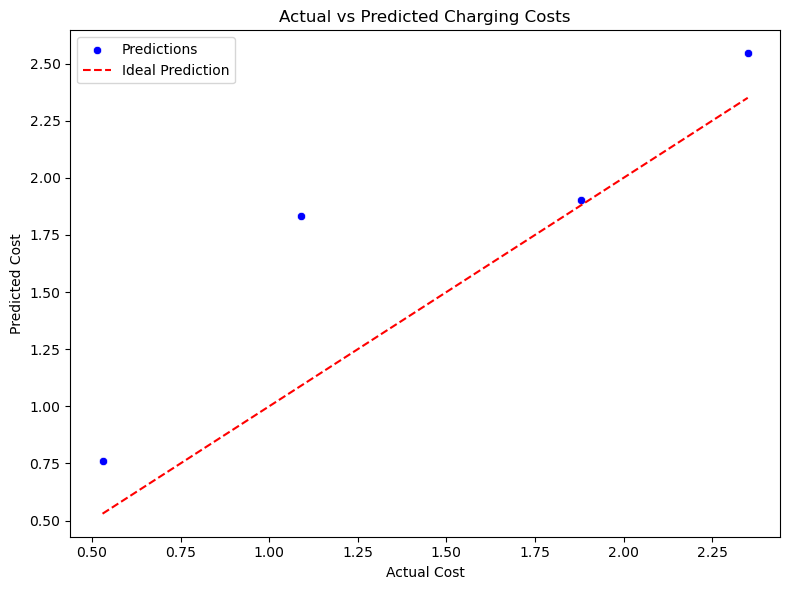

In [17]:
y_test_reset = pd.Series(y_test).reset_index(drop=True)
preds_reset = pd.Series(preds).reset_index(drop=True)

# Create a DataFrame with aligned actual vs predicted
results_df = pd.DataFrame({
    'Actual Cost': y_test_reset,
    'Predicted Cost': preds_reset
})

# Plot
plt.figure(figsize=(8, 6))
sb.scatterplot(data=results_df, x='Actual Cost', y='Predicted Cost', label='Predictions', color='blue')
plt.plot([results_df['Actual Cost'].min(), results_df['Actual Cost'].max()],
         [results_df['Actual Cost'].min(), results_df['Actual Cost'].max()],
         'r--', label='Ideal Prediction')

plt.xlabel("Actual Cost")
plt.ylabel("Predicted Cost")
plt.title("Actual vs Predicted Charging Costs")
plt.legend()
plt.tight_layout()
plt.show()

R² Score: 0.3119031174228224
RMSE: 0.5026031461254782


C:\Users\bowli\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


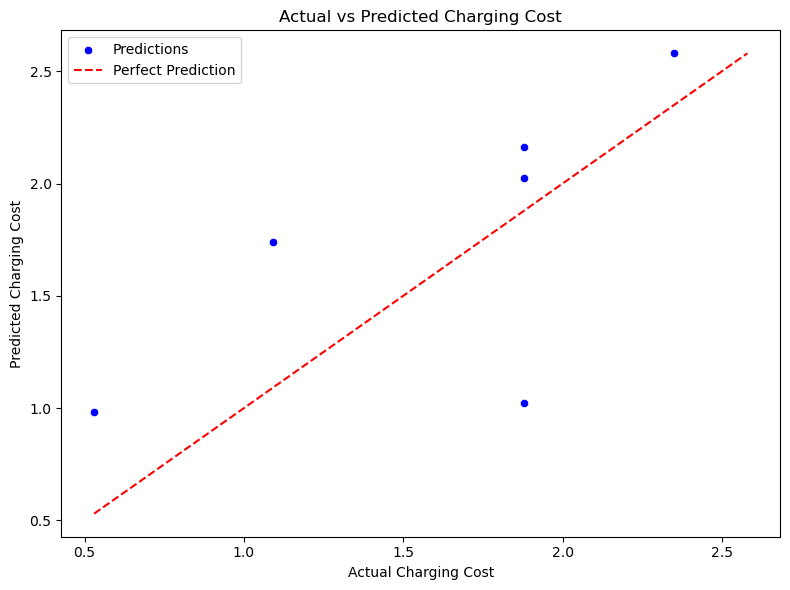

In [18]:
charging_data['date'] = pd.to_datetime(charging_data['date'])
driving_data['date'] = pd.to_datetime(driving_data['date'])

charging_data['hour'] = pd.to_datetime(charging_data['charge_time'], format='%H:%M:%S', errors='coerce').dt.hour
charging_data['day_of_week'] = charging_data['date'].dt.dayofweek

daily_trips = driving_data.groupby('date').agg({
    'miles': 'sum',
    'average_m/kwh': 'mean',
    'trip_cost': 'sum'
}).reset_index()

combined_df = pd.merge(charging_data, daily_trips, on='date', how='left')

combined_df.fillna(0, inplace=True)

encoder = OneHotEncoder(sparse_output=False)
encoded_places = encoder.fit_transform(combined_df[['charge_place']])
encoded_df = pd.DataFrame(encoded_places, columns=encoder.get_feature_names_out(['charge_place']))
combined_df = pd.concat([combined_df, encoded_df], axis=1)


features = combined_df[['day_of_week', 'hour', 'miles', 'average_m/kwh', 'trip_cost'] + list(encoded_df.columns)]
target = combined_df['cost']


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

results_df = pd.DataFrame({
    'Actual Cost': y_test.reset_index(drop=True),
    'Predicted Cost': pd.Series(y_pred)
})

# Seaborn plot
plt.figure(figsize=(8, 6))
sb.scatterplot(data=results_df, x='Actual Cost', y='Predicted Cost', label='Predictions', color='blue')

# Add ideal prediction line
min_val = min(results_df['Actual Cost'].min(), results_df['Predicted Cost'].min())
max_val = max(results_df['Actual Cost'].max(), results_df['Predicted Cost'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

# Labels and title
plt.xlabel("Actual Charging Cost")
plt.ylabel("Predicted Charging Cost")
plt.title("Actual vs Predicted Charging Cost")
plt.legend()
plt.tight_layout()
plt.show()

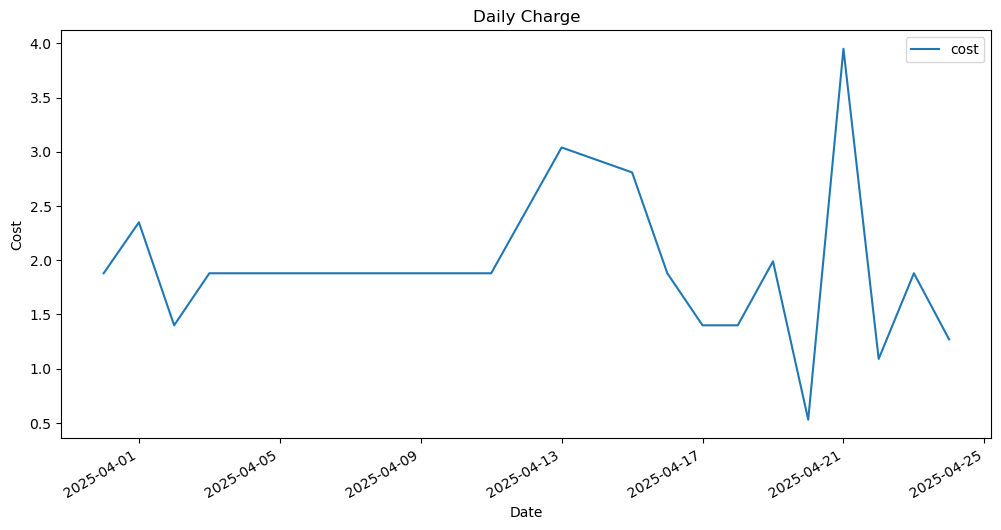

In [19]:
charging_data['date'] = pd.to_datetime(charging_data['date'])

daily_charge = charging_data.groupby(charging_data['date'].dt.date)['cost'].sum().reset_index()
daily_charge['date'] = pd.to_datetime(daily_charge['date'])
daily_charge.set_index('date', inplace=True)

daily_charge['cost'].plot(figsize=(12,6), title= 'Daily Charge')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.legend()
plt.show()

14:03:37 - cmdstanpy - INFO - Chain [1] start processing
14:03:37 - cmdstanpy - INFO - Chain [1] done processing


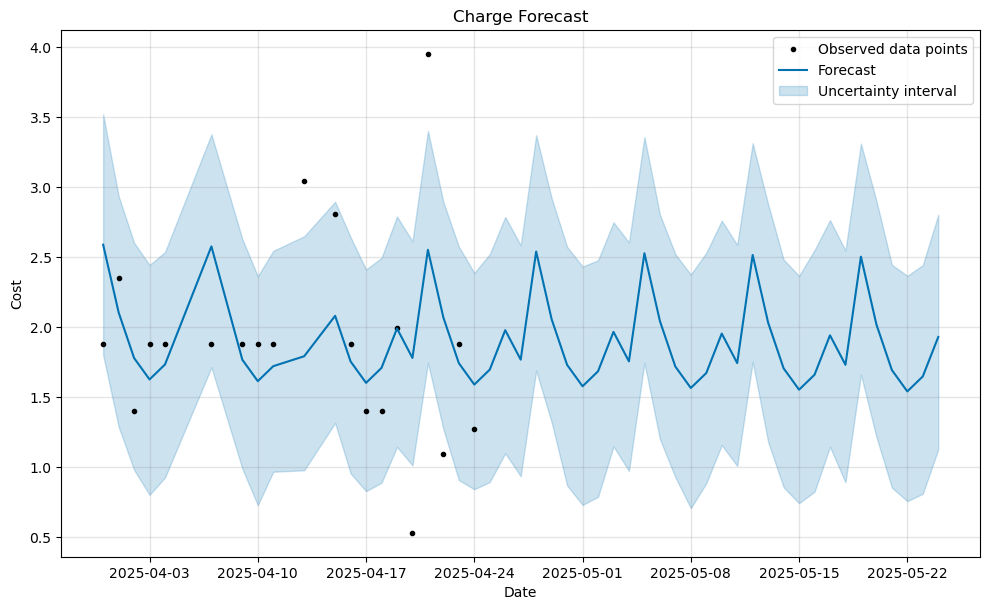

In [20]:
cd = daily_charge.reset_index().rename(columns={'date': 'ds', 'cost': 'y'})

model= Prophet()
model.fit(cd)

future= model.make_future_dataframe(periods=30)
forecast= model.predict(future)

model.plot(forecast)
plt.title("Charge Forecast")
plt.xlabel("Date")
plt.ylabel("Cost")
plt.legend()
plt.show()

In [21]:
#math so I don't have to figure out the average on my own. 
avg = driving_data['average_m/kwh'].mean()

print(avg)

4.8999999999999995


In [28]:
total_kwh = 30  
efficiency_miles_per_kWh = avg  

#folium needs distance in meters and not miles
range_miles = total_kwh * efficiency_miles_per_kWh
range_meters = range_miles * 1609.34  

#coordinates to starting location
ev_coords = (28.65106773376465, -81.33721923828125)

#creates map centered on my location chosen
m = folium.Map(location=ev_coords, zoom_start=6.5)

#add the marker to the map, and the icon is a cute car
folium.Marker(
    location=ev_coords,
    popup="Your EV Location",
    tooltip="EV Location",
    icon=folium.Icon(color="gray", icon="car", prefix="fa")
).add_to(m)

#the range based on my data
folium.Circle(
    location=ev_coords,
    radius=range_meters,
    color='blue',
    fill=True,
    fill_opacity=0.1,
    popup=f"Estimated Driving Range ({range_miles:.1f} miles)"
).add_to(m)

#saves and displays data
m.save("simple_ev_range_map.html")
m